# Test different optimizers for ANN with MNIST data. 


In [11]:
# COURSE: A deep understanding of deep learning
## SECTION: FFNs
### LECTURE: FFN to classify digits
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202210

In [12]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import time

import matplotlib.pyplot as plt
from IPython import display
# display.set_matplotlib_formats('svg')

# Import and process the data

In [13]:
# import dataset (comes with colab!)
with open('/Users/alexchen/Downloads/mnist/mnist_test.csv','rb') as f:
   data = np.loadtxt(f, delimiter=',', skiprows=1)
# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

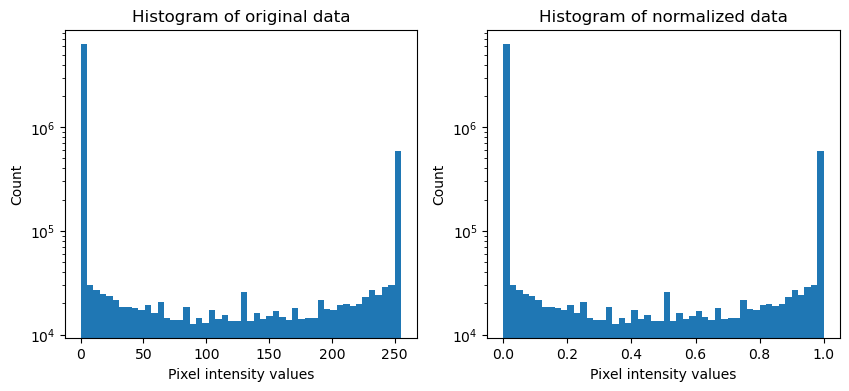

In [14]:
# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[0].set_yscale('log')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
ax[1].set_yscale('log')


plt.show()

# Create train/test groups using DataLoader

In [15]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create the DL model

In [16]:
# create a class for the model
def createTheMNISTNet(n_layers, n_units, optimizer_name, learning_rate):

  class mnistNet(nn.Module):
    def __init__(self, n_layers, n_units):
      super().__init__()

      self.n_layers = n_layers
      self.layers = nn.ModuleDict()
      ### input layer
      self.layers['input'] = nn.Linear(784,n_units)
      # hidden layer
      for i in range(self.n_layers):
        self.layers[f'fc{i}'] = nn.Linear(n_units, n_units)
      ### output layer
      self.layers['output'] = nn.Linear(n_units, 10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.layers['input'](x) )
      for i in range(self.n_layers):
        x = F.relu( self.layers[f'fc{i}'](x) )
      x = self.layers['output'](x)
      return x
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  
  # create the model instance
  net = mnistNet(n_layers, n_units)
  
  # loss function
  lossfun = nn.CrossEntropyLoss()
  # optimizer
  optimizer = getattr(torch.optim, optimizer_name)(net.parameters(),lr=learning_rate)
  # optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [17]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet(2, 2, 'SGD', 0.01)

X,y = next(iter(train_loader))
yHat = net(X)

# values are log-probability of each number (0-9)
print(yHat[0])

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

tensor([-0.5911,  0.6748, -0.1786, -0.2784, -0.0201, -0.1011, -0.6597, -0.1307,
        -0.3133, -0.6997], grad_fn=<SelectBackward0>)
 
Loss:
tensor(2.3166, grad_fn=<NllLossBackward0>)


# Create a function that trains the model

In [18]:
# a function that trains the model

def funtion2trainTheModel(n_layers, n_units, optimizer_name, learning_rate):

  # number of epochs
  numepochs = 60
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet(n_layers, n_units, optimizer_name, learning_rate)

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Run the model and show the results!

finished running SGD at 0.0001 lr in 9.12s, test acc 13.90%
finished running SGD at 0.00039810717055349735 lr in 8.67s, test acc 55.70%
finished running SGD at 0.001584893192461114 lr in 8.69s, test acc 86.90%
finished running SGD at 0.00630957344480193 lr in 8.6s, test acc 93.30%
finished running SGD at 0.025118864315095794 lr in 8.71s, test acc 95.00%
finished running SGD at 0.1 lr in 8.83s, test acc 95.70%
finished running RMSprop at 0.0001 lr in 12.77s, test acc 94.10%
finished running RMSprop at 0.00039810717055349735 lr in 12.96s, test acc 94.90%
finished running RMSprop at 0.001584893192461114 lr in 12.46s, test acc 95.30%
finished running RMSprop at 0.00630957344480193 lr in 13.64s, test acc 93.50%
finished running RMSprop at 0.025118864315095794 lr in 13.04s, test acc 64.60%
finished running RMSprop at 0.1 lr in 13.38s, test acc 10.20%
finished running Adam at 0.0001 lr in 14.88s, test acc 93.50%
finished running Adam at 0.00039810717055349735 lr in 15.08s, test acc 95.10%
fin

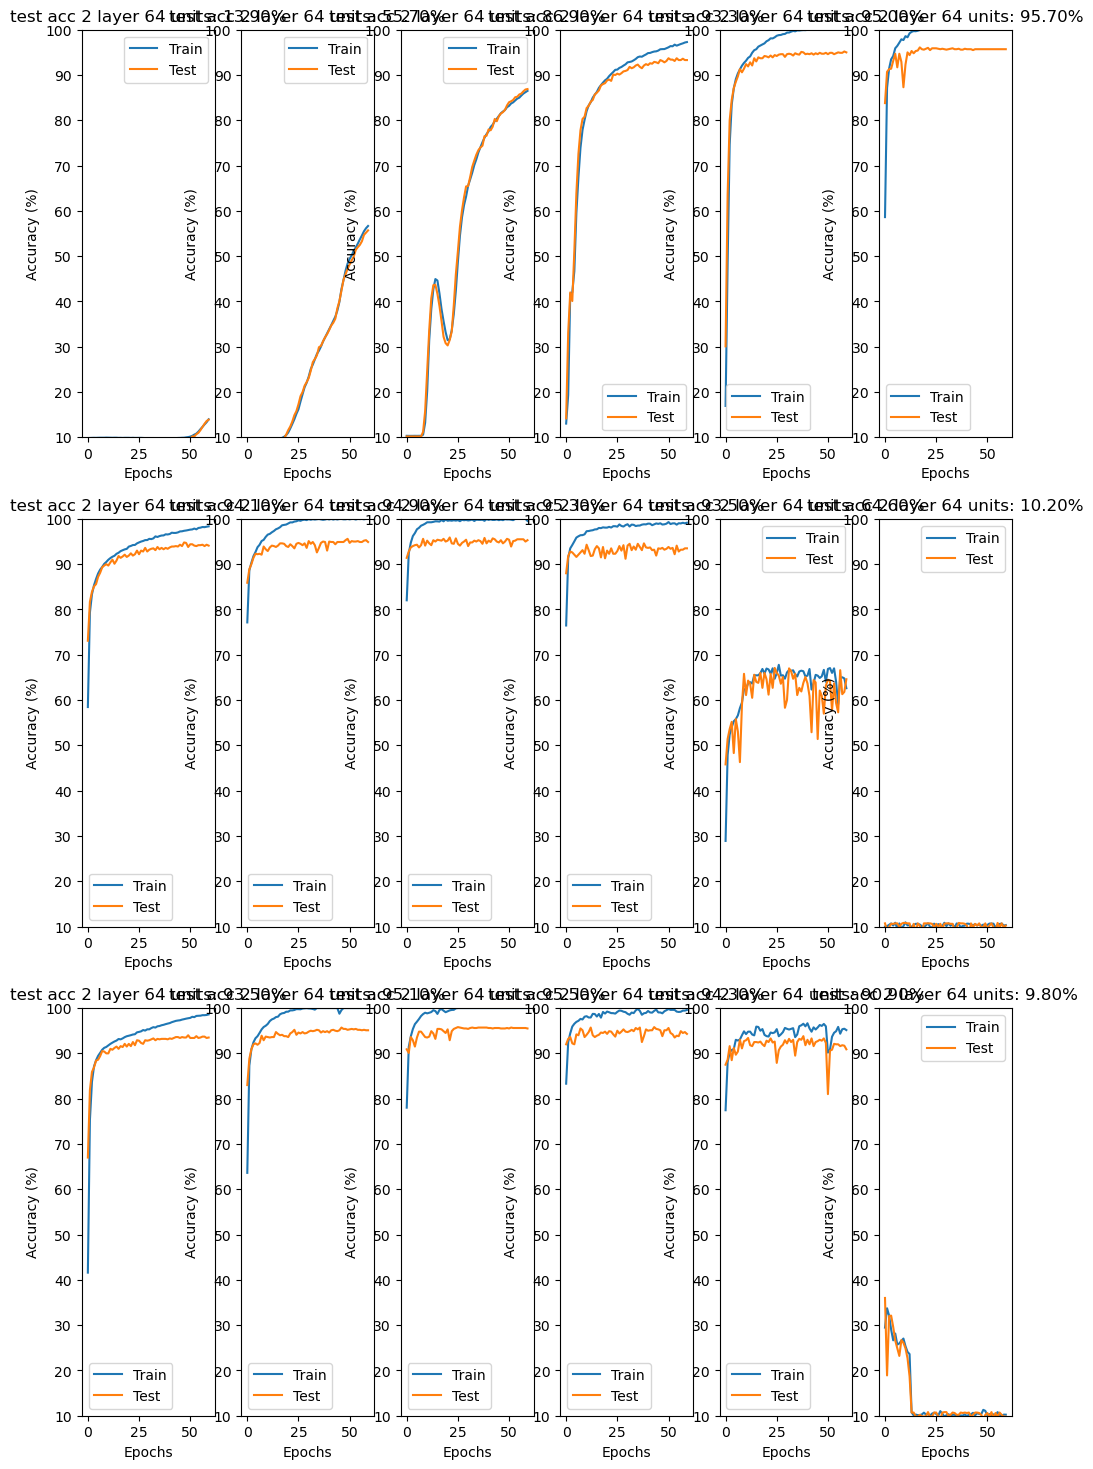

In [19]:
optimizer_name_lst = ['SGD', 'RMSprop', 'Adam']
learning_rate_lst = np.logspace(-4, -1, 6)
layers = 2
units = 64

numepochs = 60
all_trainAccs = np.zeros((len(optimizer_name_lst), len(learning_rate_lst), numepochs))
all_testAccs = np.zeros((len(optimizer_name_lst), len(learning_rate_lst), numepochs))
all_elapsed = np.zeros((len(optimizer_name_lst), len(learning_rate_lst)))

fig, ax = plt.subplots(len(optimizer_name_lst), len(learning_rate_lst), figsize=(len(optimizer_name_lst)*4, len(learning_rate_lst)*3))
for i_optimizer, optimizer in enumerate(optimizer_name_lst):
    for j_lr, lr in enumerate(learning_rate_lst):
        start = time.time()
        trainAcc,testAcc,losses,net = funtion2trainTheModel(layers, units, optimizer, lr)
        all_trainAccs[i_optimizer, j_lr] = trainAcc
        all_testAccs[i_optimizer, j_lr] = testAcc
        elapsed = time.time() - start
        all_elapsed[i_optimizer, j_lr] = elapsed
        print(f'finished running {optimizer} at {lr} lr in {round(elapsed, 2)}s, test acc {testAcc[-1]:.2f}%')

for i_optimizer, optimizer in enumerate(optimizer_name_lst):
    for j_lr, lr in enumerate(learning_rate_lst):
        trainAcc = all_trainAccs[i_optimizer, j_lr]
        testAcc = all_testAccs[i_optimizer, j_lr]
        ax[i_optimizer, j_lr].plot(trainAcc, label='Train')
        ax[i_optimizer, j_lr].plot(testAcc, label='Test')
        ax[i_optimizer, j_lr].set_xlabel('Epochs')
        ax[i_optimizer, j_lr].set_ylabel('Accuracy (%)')
        ax[i_optimizer, j_lr].set_ylim([10,100])
        ax[i_optimizer, j_lr].set_title(f'test acc {layers} layer {units} units: {testAcc[-1]:.2f}%')
        ax[i_optimizer, j_lr].legend()
plt.show()

Text(0.5, 0, 'Units per hidden layer')

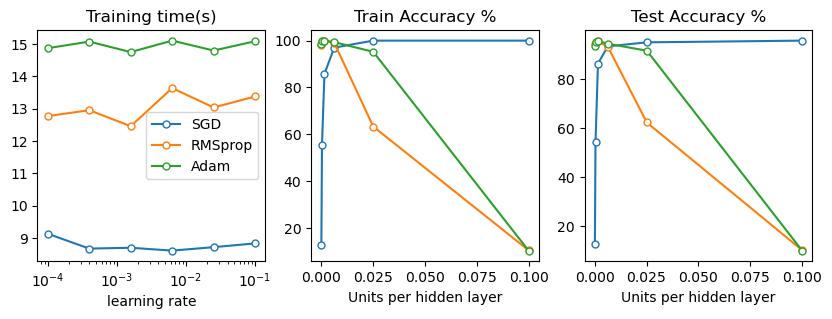

In [23]:
# plot the train and test data
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].plot(learning_rate_lst, all_elapsed.T, 'o-',markerfacecolor='w',markersize=5)
axes[0].set_xscale('log')
axes[0].set_title('Training time(s)')
axes[0].set_xlabel('learning rate')
axes[0].legend(optimizer_name_lst)
axes[1].plot(learning_rate_lst, np.mean(all_trainAccs[:, :, -5:], axis=2).T, 'o-',markerfacecolor='w',markersize=5)
axes[0].set_xscale('log')
axes[1].set_title('Train Accuracy %')
axes[1].set_xlabel('Units per hidden layer')
axes[2].plot(learning_rate_lst, np.mean(all_testAccs[:, :, -5:], axis=2).T, 'o-',markerfacecolor='w',markersize=5)
axes[0].set_xscale('log')
axes[2].set_title('Test Accuracy %')
axes[2].set_xlabel('Units per hidden layer')